In [1]:
import numpy as np
import matplotlib.pylab as plt

Previamente a leer los datos con la librería numpy y realizar el análisis, debemos resolver un problema que hay con los datos. El fichero es de tipo **csv** y el separador son las comas. Pero, hay un problema por ejemplo con la variable **grantee** ya que utiliza la coma dentro de la observación como recurso literario. Por tanto, tendremos un problema en el momento de lectura de los datos porque la coma la interpretará erróneamente como un separador de variables cuando no es así (en el caso de la variable **grantee**). Pasa lo mismo en la variable **location**, que utiliza la coma en sus observaciones para separar la latitud de la longitud. 

Para solucionar este problema vamos a leer línea a línea el fichero de los datos con la función **open()** y vamos a escribir en un nuevo fichero cada una de las líneas sustituyendo (con la función **replace()**) el separador **", "** por **"; "**. De este modo evitamos la problemática de la lectura.

In [ ]:
with open("../datos/datosB.csv","r") as f1:
    with open("../datos/datosB_V2.csv", "w") as f2:
        for linea in f1:
            ln = linea.replace(", ", "; ")
            f2.write(ln)

Ahora ya podemos leer correctamente los datos con la función **loadtxt()** de numpy. Concretamente leeremos las columnas 1, 12 y 13. Estas se corresponden al municipio, precio de la vivienda y tasa de capitalización respectivamente. Con las columans 12 y 13 no hay problema, son numéricas. En cambio la primera columna es el municipio de la vivienda, que es texto. Por tanto, para poder tratarlo con numpy, convertiremos los bytes que leemos a un dato **int** utilizando la función **from_bytes()**.

In [2]:
data = np.loadtxt("../datos/datosB_V2.csv", 
                  delimiter = ",", 
                  usecols = (0, 11, 12), 
                  skiprows = 1,
                  converters = {0: lambda s: int.from_bytes(s, byteorder = "big")})

El objetivo ahora será tener un mapping entre el código del municipio y su representación en formato texto. Para ello primero obtendremos los diferentes códigos de los municipios que tenemos en el dataset. Para ello usamos la función **unique()**

In [3]:
codigos = np.unique(data[:,0])
print(codigos)

[16971. 16984. 19790. 20814. 21321.]


Ahora vamos a obtener la representación textual de cada uno de estos códigos. Para ellos vamos a utilizar la función **map()** que aplica una función a todos los elementos de una colección. La función que aplicaremos a cada elemento del array de códigos será evidentemente una función que devuelva la representación textual del número entero. Una opción sería definir una función en Python con **def**. Pero usaremos una función **lambda** puesto que no solo la necesitamos para realizar la conversión. 

Para transformar un número entero a su representación textual, primero transformamos el número entero a bytes con la función **to_bytes()** de la clase **int**. Necesitamos especificar el número de bytes, que en este casos será 2 ya que todos los códigos son de 2 letras. Una vez tenemos la representación en bytes del número entero, usamos la función **decode()** para obtener la representación textual que queríamos.

In [4]:
municipios = list(map(lambda code: int(code).to_bytes(length = 2, byteorder = "big").decode(), codigos))
print(municipios)

['BK', 'BX', 'MN', 'QN', 'SI']


Finalmente guardaremos en un diccionario el mapping entre el código del municipio y su representación en formato textual.

In [5]:
mapping = {}

for i in range(len(codigos)):
    mapping[codigos[i]] = municipios[i]

print(mapping)

{16971.0: 'BK', 16984.0: 'BX', 19790.0: 'MN', 20814.0: 'QN', 21321.0: 'SI'}


Vamos a dibujar un diagrama de barras para conocer la cantidad de viviendas que tenemos en cada muncipio. Para ello usaremos la función **bar()**. Esta función necesita que le proporcionemos los municipios y las frecuencias. Los municipios los podemos obtener fácilmente, ya que son los valores del diccionario. La frecuencia de cada municipio también es fácil de obtener con la función **unique()** añadiendo **return_counts = True** y seleccionando solamente las frecuencias.

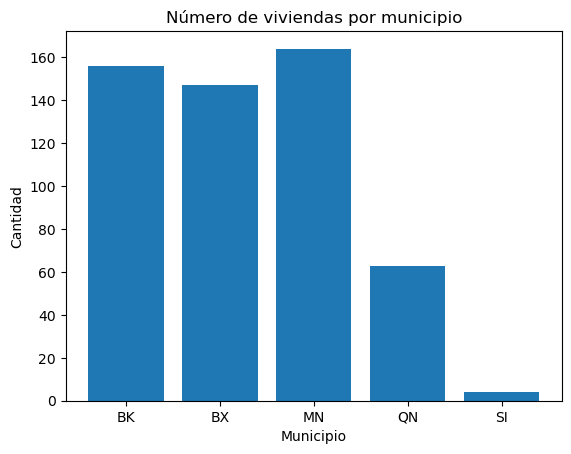

In [6]:
_ = plt.bar(mapping.values(), np.unique(data[:,0], return_counts=True)[1])
plt.title("Número de viviendas por municipio")
plt.ylabel("Cantidad")
plt.xlabel("Municipio")
plt.show()

Claramente hay una asimetría en el número de viviendas según el municipio. Por ejemplo los barrios BK, BX y MN tienen una cantidad parecida de viviendas. Pero los municipios QN tiene una cantidad significativamente menor a los municipios anteriores. Y, el municipio SI, tiene aún menos viviendas que QN.

A continuación vamos a calcular el precio medio y la desviación estándar del precio de las viviendas según el municipio. Para ello usaremos el bucle **for**, donde en cada iteración encontraremos la serie de precios de las viviendas de un municipio y calcularemos su media y desviación. 

Para encontrar la serie de precios de viviendas de cada municipio, usamos la función **where()** que nos proporciona los índices del array que cumplen la condición que se proporciona como parámetro. Guardamos esos datos en una variable. Y, con la función **mean()** y **std()** podemos calcular la media y desviacióne estándar.

In [7]:
# Media de precio por municipio
for codigo in codigos:
    viviendas_municipio = data[np.where(data[:,0] == codigo)]
    media = np.mean(viviendas_municipio[:,1])
    sd = np.std(viviendas_municipio[:,1])
    print(f' El precio medio de la vivienda del municipio {mapping[codigo]} es: {media} y su desviación estándard es: {sd}')

 El precio medio de la vivienda del municipio BK es: 8691022.108974358 y su desviación estándard es: 7989399.884687077
 El precio medio de la vivienda del municipio BX es: 6659420.789115646 y su desviación estándard es: 4400425.318210916
 El precio medio de la vivienda del municipio MN es: 12382693.445121951 y su desviación estándard es: 12075467.302295946
 El precio medio de la vivienda del municipio QN es: 9266994.206349207 y su desviación estándard es: 9494142.076305142
 El precio medio de la vivienda del municipio SI es: 2206250.0 y su desviación estándard es: 1088343.7818538772


Claramente, la variación de los precios de las viviendas por municipio es muy elevada. Por tanto la media podría resultar una mala medida para tener una idea de la tendencia central de la distribución.

Veamos como efectivamente la media podría no resultar muy fiable. Vamos a calcular, para cada municipio, la probabilidad de que una vivienda tenga un precio superior a la media de los precios de las viviendas del municipio.

Para ello en primer lugar calcularemos las medias y las guardaremos en un array. Seguidamente calcularemos la probabilidad como el número de viviendas que cumplen la condición entre el número total de viviendas del municipio.

Crearemos en primer lugar un array de ceros con la función **zeros()** de dimensión el total de municipios. A continuación con un **for** encontramos la media de lo precios de las viviendas del municipio y la guardamos en el array de medias. Para encontrar la media, el proceso es análogo al que hemos explicado anteriormente.

Una vez tenemos el vector de medias volvemos a realizar un bucle **for** para calcular la probabilidad mencionada en cada municipio. En cada iteración guardamos los datos de las viviendas del municipio en una variable. Y, calculamos la probabilidad como hemos mencionado. 

Notemos que para calcular los casos favorables (los casos que cumplen la condición) usaremos la función **where()** que nos devolverá las posiciones de las viviendas que cumplen la condición. Por tanto, para conocer la cantidad, simplemente con la función **len()** la podemos obtener. Por otro lado los casos totales es simplemente el número de viviendas del municipio, que podemos conocer con la función **len()**.

In [8]:
# Probabilidad de que una vivienda de un municipio tenga un precio superior a la media de los precios de las viviendas del municipio donde se ubica la vivienda
medias = np.zeros(len(codigos))
for i in range(len(codigos)):
    medias[i] = np.mean(data[np.where(data[:,0] == codigos[i])][:,1])

for i in range(len(codigos)):
    viviendas_municipio = data[np.where(data[:,0] == codigos[i])]
    prob = len(np.where(viviendas_municipio[:,1]>=medias[i])[0])/len(viviendas_municipio)
    print(f'La probabilidad de que una vivienda del municipio {mapping[codigos[i]]} tenga un precio mayor a la mediana es de: {prob}')

La probabilidad de que una vivienda del municipio BK tenga un precio mayor a la mediana es de: 0.2948717948717949
La probabilidad de que una vivienda del municipio BX tenga un precio mayor a la mediana es de: 0.38095238095238093
La probabilidad de que una vivienda del municipio MN tenga un precio mayor a la mediana es de: 0.2926829268292683
La probabilidad de que una vivienda del municipio QN tenga un precio mayor a la mediana es de: 0.2698412698412698
La probabilidad de que una vivienda del municipio SI tenga un precio mayor a la mediana es de: 0.5


Vemos que en todos los casos excepto el muncipio SI, la probabilidad es baja. Por lo que deducimos que la mayor parte de los datos están concentrados en la parte baja de la distribución. Cabe destacar que en el caso del muncipio SI, tan solo tenemos 4 observaciones. Por este motivo probablemente la probabilidad es de 0.5.

Finalizamos el análisis calculando la moda de la tasa de capitalización en cada muncipio. Recordemos que la moda es el valor que aparece con mayor frecuencia. El proceso para calcular la moda es bastante parecido al resto de procesos ya explicado en este análisi. Primero guardamos en una variable los datos del muncipio. Seguidamente obtenemos con la función **unique()** los valores únicos de la tasa de capitalización y su frecuencia. Por definción la moda es el valor que aprece con mayor frecuencia. Por tanto la podemos calcular fácilmente encontrando los valores que tienen una frecuencia igual al máximo de las frecuencias.

Notemos que podría ocurrir que la moda no sea única.

In [9]:
# Obtener la moda de la tasa de capitalización por municipio
for codigo in codigos:
    datos_municipio = data[np.where(data[:,0] == codigo)]
    valores, counts = np.unique(datos_municipio[:,2], return_counts = True)
    moda = valores[counts == np.max(counts)]
    print(f' La moda de la tasa de la capitalización en el municipio {mapping[codigo]} es: {moda}')

 La moda de la tasa de la capitalización en el municipio BK es: [0.033]
 La moda de la tasa de la capitalización en el municipio BX es: [0.029 0.03  0.032 0.035]
 La moda de la tasa de la capitalización en el municipio MN es: [0.028 0.032]
 La moda de la tasa de la capitalización en el municipio QN es: [0.039]
 La moda de la tasa de la capitalización en el municipio SI es: [0.041 0.044 0.046 0.068]
